# MAF vs lead variant VEP score

This notebook compares the MAF (Minor Allele Frequency) of credible set lead variants with their VEP (Variant Effect Predictor) scores


In [2]:
from __future__ import annotations

import random
from collections.abc import Callable

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

random.seed(42)
sns.set_style("white")
sns.set_context("paper", font_scale=1.0)
sns.set_palette(sns.color_palette("coolwarm"))
pl.Config.set_tbl_rows(100)


polars.config.Config

## Methods


In [3]:
def classify_by_pip_threshold(pip: pl.Expr, threshold: float = 0.9) -> pl.Expr:
    """Classify dataset by posteriorProbability threshold."""
    return pl.when(pip >= threshold).then(True).otherwise(False).alias(f"is{threshold * 100:.0f}pip")


class VepScoringGroup:
    def __init__(self, score: str, label: str):
        assert isinstance(score, (int, float)), "Score must be a number"
        assert isinstance(label, str), "Label must be a string"
        self.score = score
        self.label = label

    def __gt__(self, other: VepScoringGroup) -> bool:
        return self.score > other.score

    def __lt__(self, other: VepScoringGroup) -> bool:
        return self.score < other.score

    def __eq__(self, other: VepScoringGroup) -> bool:
        return self.score == other.score


def classify_by_vep_score(effect: pl.Expr, scores: list[VepScoringGroup] | None = None) -> pl.Expr:
    """Classify the vep score by given scores."""
    if not scores:
        scores = [
            VepScoringGroup(score=0.0, label="very low"),
            VepScoringGroup(score=0.1, label="low"),
            VepScoringGroup(score=0.33, label="medium"),
            VepScoringGroup(score=0.66, label="high"),
            VepScoringGroup(score=1.0, label="very high"),
        ]
    expr = pl.when(False).then(None)
    groups = sorted(scores, reverse=True)
    for group in groups:
        expr = expr.when(effect.struct.field("normalisedScore") >= group.score).then(pl.lit(group.label))
    expr = expr.otherwise(pl.lit(None)).alias("vepScoreClass")
    return expr


class VariantFrequencyGroup:
    def __init__(self, condition: Callable[[pl.Expr], pl.Expr], label: str) -> None:
        self.label = label
        self.condition = condition


def classify_by_altering(vep_score: pl.Expr) -> pl.Expr:
    """Classify variants based on altering status."""
    expr = pl.when(vep_score.struct.field("normalisedScore") >= 0.66).then(pl.lit("protein_altering"))
    expr = expr.otherwise(pl.lit("non-protein_altering"))
    return expr.alias("alteringStatus")


def classify_by_maf(maf: pl.Expr, frequency_groups: list[VariantFrequencyGroup] | None = None) -> pl.Expr:
    """Classify variants based on the maf thresholds."""
    if not frequency_groups:
        frequency_groups = [
            VariantFrequencyGroup(
                lambda maf: (maf >= 0.01), "common"
            ),  # in case of adding lowFrequency change the threshold
            # VariantFrequencyGroup(lambda maf: ((maf <= 0.05) & (maf >= 0.01)), "lowFrequency"),
            VariantFrequencyGroup(lambda maf: (maf < 0.01), "rare"),
        ]

    maf = pl.col("majorPopulationMAF")
    expr = pl.when(False).then(None)
    for group in frequency_groups:
        expr = expr.when(group.condition(maf)).then(pl.lit(group.label))
    return expr.alias("MAFClass")


def binnarize_maf(maf: pl.Expr, frequency_groups: list[VariantFrequencyGroup] | None = None) -> pl.Expr:
    """Classify variants based on the maf thresholds."""
    if not frequency_groups:
        frequency_groups = [
            VariantFrequencyGroup(lambda maf: ((maf >= 0.0) & (maf < 0.01)), "<0.0, 0.01)"),
            VariantFrequencyGroup(lambda maf: ((maf >= 0.01) & (maf < 0.05)), "<0.01, 0.05)"),
            VariantFrequencyGroup(lambda maf: ((maf >= 0.05) & (maf < 0.1)), "<0.05, 0.1)"),
            VariantFrequencyGroup(lambda maf: ((maf >= 0.1) & (maf < 0.15)), "<0.1, 0.15)"),
            VariantFrequencyGroup(lambda maf: ((maf >= 0.15) & (maf < 0.2)), "<0.15, 0.2)"),
            VariantFrequencyGroup(lambda maf: ((maf >= 0.2) & (maf < 0.25)), "<0.2, 0.25)"),
            VariantFrequencyGroup(lambda maf: ((maf >= 0.25) & (maf < 0.3)), "<0.25, 0.3)"),
            VariantFrequencyGroup(lambda maf: ((maf >= 0.3) & (maf < 0.35)), "<0.3, 0.35)"),
            VariantFrequencyGroup(lambda maf: ((maf >= 0.35) & (maf < 0.4)), "<0.35, 0.4)"),
            VariantFrequencyGroup(lambda maf: ((maf >= 0.4) & (maf < 0.45)), "<0.4, 0.45)"),
            VariantFrequencyGroup(lambda maf: ((maf >= 0.45) & (maf < 0.5)), "<0.45, 0.5)"),
            VariantFrequencyGroup(lambda maf: (maf == 0.5), ">0.5"),
        ]

    maf = pl.col("majorPopulationMAF")
    expr = pl.when(False).then(None)
    for group in frequency_groups:
        expr = expr.when(group.condition(maf)).then(pl.lit(group.label))
    return expr.alias("MAFBin")


def classify_by_est_beta(est_beta: pl.Expr, beta_threshold: float | None = None) -> pl.Expr:
    """Classify the estimated beta by given threshold."""
    if not beta_threshold:
        beta_threshold = 0.5
    expr = (
        pl.when(est_beta.abs() >= beta_threshold)
        .then(pl.lit(f">={beta_threshold:.1f}"))
        .otherwise(pl.lit(f"<{beta_threshold:.1f}"))
    )
    return expr.alias("estBetaClass")


def adjust_study_type(study_type: pl.Expr) -> pl.Expr:
    """Adjust study type based on qtl distance type."""
    qtl_distance_type = (
        pl.when(pl.col("isTransQtl"))
        .then(pl.lit("trans"))
        .when(~pl.col("isTransQtl"))
        .then(pl.lit("cis"))
        .otherwise(pl.lit(None))
    )
    adjusted_study_type = (
        pl.when(study_type == "pqtl")
        .then(pl.concat_str(qtl_distance_type, study_type, separator="-"))
        .otherwise(study_type)
        .alias("studyType")
    )
    return adjusted_study_type


def prepare_dataset(df: pl.DataFrame) -> pl.DataFrame:
    """Prefilter based on (7) criteria before the main analysis."""
    initial_n = df.shape[0]
    study_type = pl.col("studyType")

    var_id = pl.col("variantId")
    trait_id = (
        pl.when(study_type == "gwas")
        .then(pl.col("traitFromSourceMappedIds").list.sort().list.join(separator=";"))
        .otherwise(pl.col("geneId"))
        .alias("traitId")
    )
    credible_set_id = pl.concat_str(var_id, trait_id, separator=":").alias("credibleSetId")
    credible_set_id_count = pl.len().over(credible_set_id).alias("credibleSetIdCount")
    df = df.with_columns(var_id, trait_id, credible_set_id, credible_set_id_count)
    # apply filtering
    df = (
        df.filter(pl.col("posteriorProbability") >= 0.9)
        .filter(pl.col("credibleSetIdCount") >= 2)
        .unique(pl.col("credibleSetId"))
    )
    following_n = df.shape[0]
    print(f"Initial number of variants: {initial_n}")
    print(f"Following number of variants: {following_n}")
    print(f"Number of variants removed: {initial_n - following_n}")
    print(f"Percentage of variants removed: {(initial_n - following_n) / initial_n:.2%}")
    return df


class StudyType:
    def __init__(self, study_type: str, n: int):
        self.study_type = study_type
        self.n = n

    def __eq__(self, other: StudyType) -> bool:
        return self.n == other.n

    def __lt__(self, other: StudyType) -> bool:
        return self.n < other.n

    def __gt__(self, other: StudyType) -> bool:
        return self.n > other.n


def remove_empty_maf(df: pl.DataFrame) -> pl.DataFrame:
    """Remove rows with empty MAF values."""
    initial_n = df.shape[0]
    df = df.filter(pl.col("majorPopulationMAF").is_not_null())
    following_n = df.shape[0]
    print(f"Initial number of variants: {initial_n}")
    print(f"Following number of variants: {following_n}")
    print(f"Number of variants removed: {initial_n - following_n}")
    print(f"Percentage of variants removed: {(initial_n - following_n) / initial_n:.2%}")
    return df


def vep_score_proportion(vep_score: pl.Expr, maf_bin: pl.Expr, threshold=0.66) -> pl.Expr:
    """Calculate the proportion and the std error of the proportion."""
    proportion_class = (
        pl.when(vep_score.struct.field("normalisedScore") >= threshold).then(1).otherwise(0).alias("proportionClass")
    )
    protein_altering = proportion_class.sum().over(maf_bin).alias("proteinAlteringInMAFBin")
    non_protein_altering = (proportion_class.count().over(maf_bin) - protein_altering).alias(
        "nonProteinAlteringInMAFBin"
    )
    all = protein_altering + non_protein_altering
    score_proportion = (protein_altering / non_protein_altering).alias("proportion")
    proportion_stderr = ((score_proportion * (1 - score_proportion)) / all).sqrt().alias("stdErr")
    return pl.struct(
        proportion_class, protein_altering, non_protein_altering, score_proportion, proportion_stderr
    ).alias("vepProportion")


## Data


In [4]:
dataset = (
    pl.read_parquet("../../data/rescaled-betas.parquet")
    .with_columns(
        adjust_study_type(pl.col("studyType")),
        classify_by_maf(pl.col("majorPopulationMAF")),
        classify_by_vep_score(pl.col("vepEffect")),
        classify_by_est_beta(pl.col("rescaledStatistics").struct.field("estimatedBeta")),
        classify_by_altering(pl.col("vepEffect")),
        binnarize_maf(pl.col("majorPopulationMAF")),
    )
    .sort("majorPopulationMAF", descending=True)
)

filtered_dataset = remove_empty_maf(dataset)
replicated_lead_variants_dataset = prepare_dataset(filtered_dataset)


Initial number of variants: 2615028
Following number of variants: 2613411
Number of variants removed: 1617
Percentage of variants removed: 0.06%
Initial number of variants: 2613411
Following number of variants: 78301
Number of variants removed: 2535110
Percentage of variants removed: 97.00%


## Plot the MAF vs protein altering - VEP score


In [4]:
maf_vep = (
    replicated_lead_variants_dataset.filter(pl.col("studyType") == "gwas")
    .select(
        "variantId", "majorPopulationMAF", pl.col("vepEffect").struct.field("normalisedScore"), pl.col("alteringStatus")
    )
    .unique("variantId")
    .filter((pl.col("majorPopulationMAF").is_not_null()) & (pl.col("majorPopulationMAF") > 0))
    .sort("majorPopulationMAF", descending=True)
)
maf_vep_agg = (
    maf_vep.group_by("normalisedScore")
    .agg(pl.col("majorPopulationMAF").mean().alias("meanMAF"))
    .sort("meanMAF", descending=True)
)
maf_vep_agg


normalisedScore,meanMAF
f64,f64
0.1,0.22161
0.0,0.21967
0.33,0.173537
0.66,0.091379
1.0,0.047195


Text(0.5, 1.0, 'VEP normalised score vs Mean MAF')

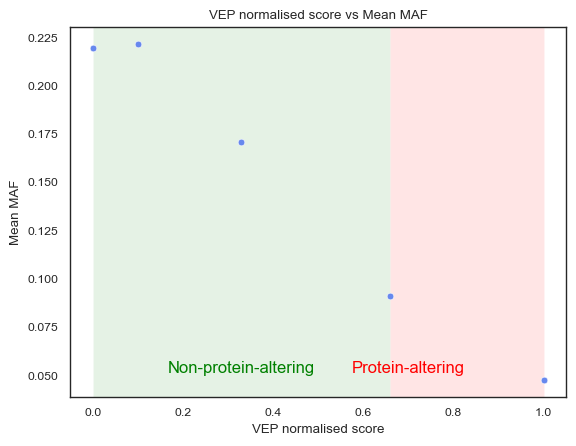

In [23]:
ax = sns.scatterplot(maf_vep_agg, x="normalisedScore", y="meanMAF")
protein_alt = patches.Rectangle(
    xy=(0.66, 0.00), height=0.25, width=0.34, linewidth=1, facecolor="red", zorder=-1, alpha=0.1
)
non_protein_alt = patches.Rectangle(
    xy=(0.00, 0.00), height=0.25, width=0.66, linewidth=1, facecolor="green", zorder=-1, alpha=0.1
)
ax.add_patch(non_protein_alt)
ax.add_patch(protein_alt)
ax.text(
    0.7,
    0.05,
    "Protein-altering",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=12,
    color="red",
)
ax.text(
    0.33,
    0.05,
    "Non-protein-altering",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=12,
    color="green",
)
plt.xlabel("VEP normalised score")
plt.ylabel("Mean MAF")
plt.title("VEP normalised score vs Mean MAF")


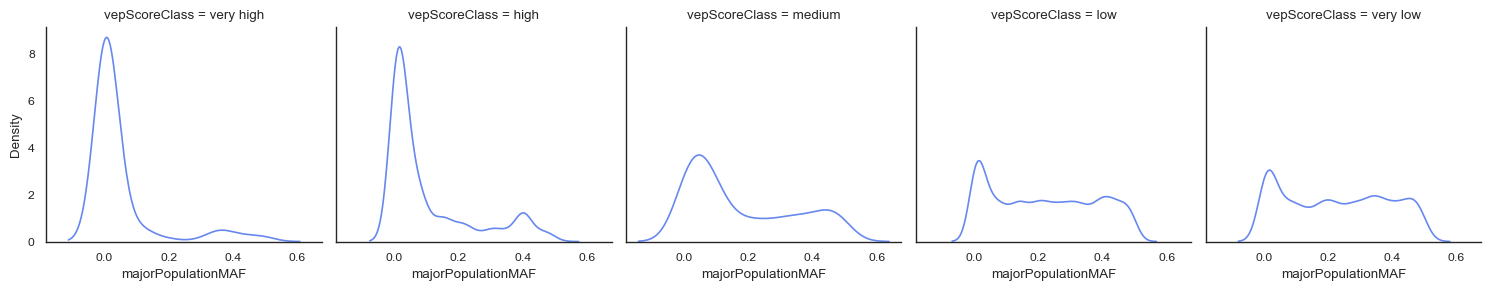

In [5]:
data = (
    replicated_lead_variants_dataset.filter(pl.col("studyType") == "gwas")
    .select("majorPopulationMAF", pl.col("vepScoreClass"), pl.col("vepEffect").struct.field("normalisedScore"))
    .sort("normalisedScore", descending=True)
)

fig = sns.FacetGrid(data=data, col="vepScoreClass")
fig.map_dataframe(sns.kdeplot, x="majorPopulationMAF")


<Axes: xlabel='majorPopulationMAF', ylabel='Density'>

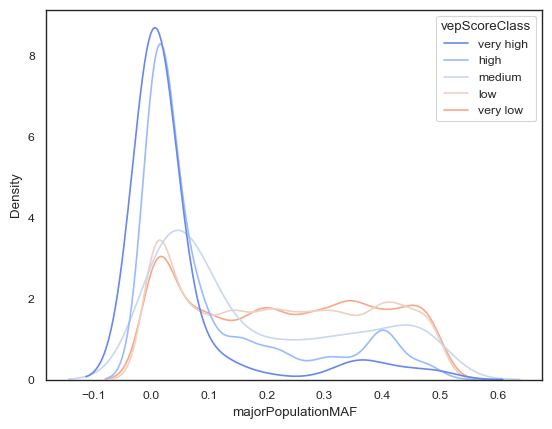

In [7]:
sns.kdeplot(data=data, x="majorPopulationMAF", hue="vepScoreClass", common_norm=False)


## Binned maf vs vep_score proportion


Number of data points in <0.1, 0.2) MAF bin: 0
Number of protein-coding variants in <0.1, 0.2) MAF bin: 0
shape: (0, 4)
┌─────────────────────────┬────────────────────────────┬────────────┬────────┐
│ proteinAlteringInMAFBin ┆ nonProteinAlteringInMAFBin ┆ proportion ┆ stdErr │
│ ---                     ┆ ---                        ┆ ---        ┆ ---    │
│ i32                     ┆ u32                        ┆ f64        ┆ f64    │
╞═════════════════════════╪════════════════════════════╪════════════╪════════╡
└─────────────────────────┴────────────────────────────┴────────────┴────────┘
shape: (11, 5)
┌──────────────┬────────────┬──────────┬────────────────────┬───────────┐
│ MAFBin       ┆ proportion ┆ stdErr   ┆ majorPopulationMAF ┆ nVariants │
│ ---          ┆ ---        ┆ ---      ┆ ---                ┆ ---       │
│ str          ┆ f64        ┆ f64      ┆ f64                ┆ u32       │
╞══════════════╪════════════╪══════════╪════════════════════╪═══════════╡
│ <0.0, 0.01)  ┆ 0.44

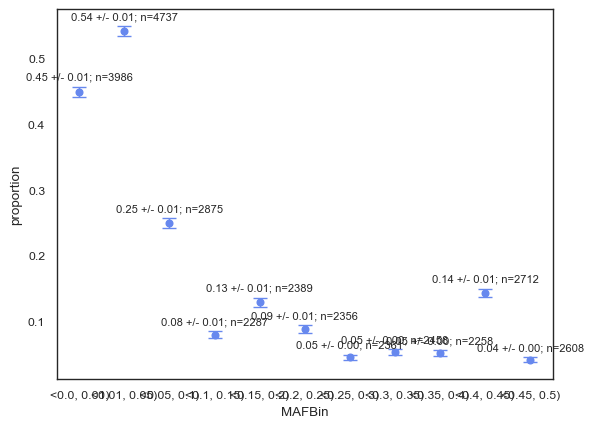

In [9]:
data = (
    replicated_lead_variants_dataset.filter(pl.col("studyType") == "gwas")
    .with_columns(
        vep_score_proportion(pl.col("vepEffect"), pl.col("MAFBin")),
    )
    .select(
        pl.col("vepProportion").struct.unnest(),
        pl.col("variantId"),
        pl.col("majorPopulationMAF"),
        pl.col("MAFBin"),
        pl.col("vepEffect").struct.field("normalisedScore"),
    )
)
# sanity check
n_data_group = data.filter(pl.col("MAFBin") == "<0.1, 0.2)").shape[0]
n_data_protein_coding = data.filter(pl.col("MAFBin") == "<0.1, 0.2)").filter(pl.col("normalisedScore") >= 0.66).shape[0]
print(f"Number of data points in <0.1, 0.2) MAF bin: {n_data_group}")
print(f"Number of protein-coding variants in <0.1, 0.2) MAF bin: {n_data_protein_coding}")
# print(
#     f"Proportion of protein-coding variants in <0.1, 0.2) MAF bin: {n_data_protein_coding / (n_data_group - n_data_protein_coding):.2%}"
# )
actual = data.filter(pl.col("MAFBin") == "<0.1, 0.2)").select(
    "proteinAlteringInMAFBin",
    "nonProteinAlteringInMAFBin",
    "proportion",
    "stdErr",
)
print(actual.limit(1))

grouped_data = (
    data.group_by("MAFBin")
    .agg(
        pl.first("proportion"),
        pl.first("stdErr"),
        pl.mean("majorPopulationMAF"),
        pl.count("variantId").alias("nVariants"),
    )
    .sort("majorPopulationMAF", descending=False)
)
print(grouped_data)

# Plotting the proportion of protein-altering variants in different MAF bins
fig = sns.scatterplot(data=grouped_data, x="MAFBin", y="proportion")
fig.errorbar(
    x=grouped_data["MAFBin"],
    y=grouped_data["proportion"],
    yerr=grouped_data["stdErr"],
    fmt="o",
    capsize=5,
    elinewidth=1,
    markeredgewidth=1,
)
# Add labels to the points
for i, row in grouped_data.to_pandas().iterrows():
    fig.text(
        x=i,
        y=row["proportion"] + row["stdErr"] + 0.01,
        s=f"{row['proportion']:.2f} +/- {row['stdErr']:.2f}; n={row['nVariants']}",
        horizontalalignment="center",
        fontsize=8,
    )


In [ ]:
replicated_lead_variants_dataset.write_parquet(
    "../../data/replicated-lead-variants.parquet",
)
